## Imports

In [119]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor


import numpy as np # numpy library
import scipy.linalg as lng # linear algebra from scipy library
from sklearn import preprocessing as preproc # load preprocessing function
import seaborn as sns
from sklearn.inspection import permutation_importance

sns.set() # Set searborn as default 
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

import scipy.io as io
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import GridSearchCV 

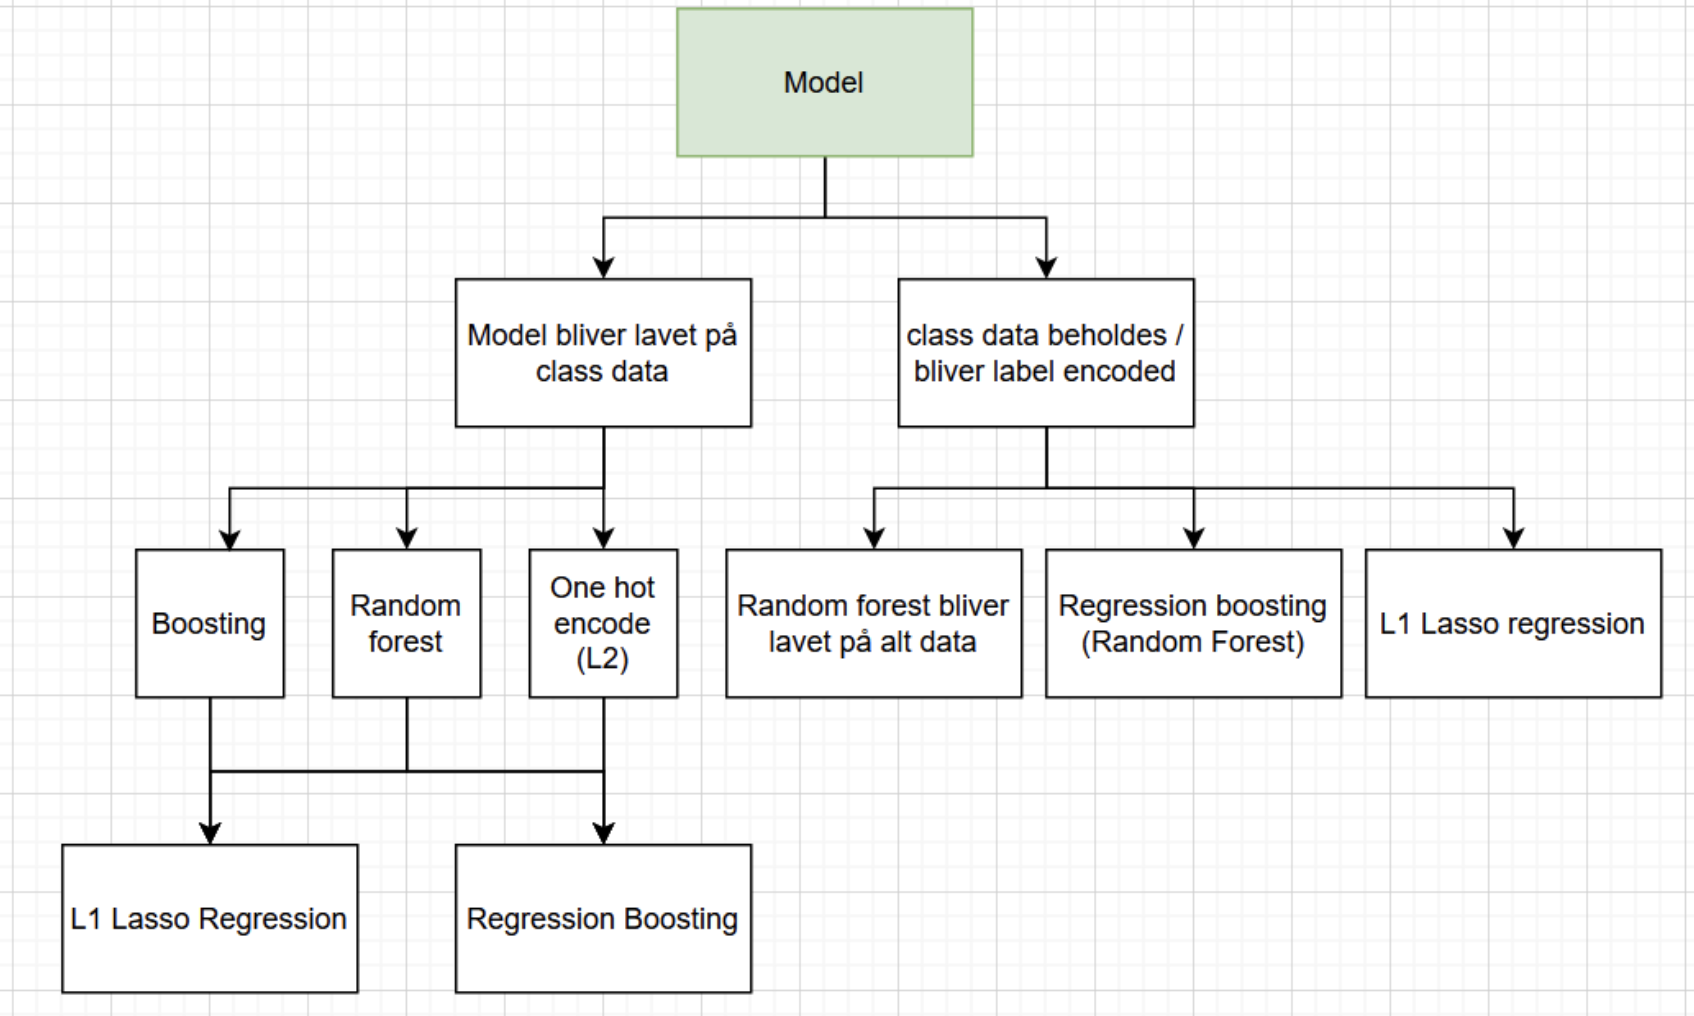

## Load dataset

In [120]:
# Read the data

# Read data from csv file 
raw_data = pd.read_csv('case1Data.txt')

# Giving NaN values the correct NaN value 
raw_data = raw_data.replace(' NaN', np.nan)

# Splitting in X and y
y = raw_data['y']
X_num = raw_data.loc[:, ' x_ 1':' x_95'].astype(float) 
X_cat = raw_data.loc[:, ' C_ 1':' C_ 5'] 

In [121]:
X_cat

,C_ 1,C_ 2,C_ 3,C_ 4,C_ 5
0,H,H,I,K,J
1,K,H,J,G,G
2,I,H,G,H,G
3,NaN,H,K,K,G
4,G,H,H,K,H
...,...,...,...,...,...
95,I,H,J,G,G
96,I,H,K,I,K
97,NaN,H,I,K,J
98,I,H,K,H,G


In [45]:
X_num.isna().sum().mean() # Check for NaN values

14.536842105263158

In [44]:
X_num[' x_ 1'].isna().sum() # Check for NaN values

16

## Initial data investigation 

In [6]:
# Basic stats and distribution

# Basic stats 
raw_data.describe()


,y
count,100.000000
mean,-9.449225
std,54.637475
min,-178.046246
25%,-44.109740
50%,-5.108532
75%,24.499702
max,113.446867


In [117]:
# Compute the correlation matrix
corr_matrix = X_num.corr()

# Flatten the correlation matrix to a long format
corr_long = corr_matrix.unstack().reset_index()
corr_long.columns = ['Feature1', 'Feature2', 'Correlation']

# Remove self-correlations (where Feature1 and Feature2 are the same)
corr_long = corr_long[corr_long['Feature1'] != corr_long['Feature2']]

# Remove duplicate pairs
corr_long['FeaturePair'] = corr_long.apply(lambda x: tuple(sorted([x['Feature1'], x['Feature2']])), axis=1)
corr_long = corr_long.drop_duplicates(subset=['FeaturePair'])

# Sort by absolute value of correlation coefficient
corr_long['AbsCorrelation'] = corr_long['Correlation'].abs()
top40_pairs = corr_long.sort_values(by='AbsCorrelation', ascending=False).head(40)

# The top 20 pairs are in top20_pairs
corr_long.sort_values(by='AbsCorrelation', ascending=False).head(100)

,Feature1,Feature2,Correlation,FeaturePair,AbsCorrelation
1962,x_21,x_63,0.756355,"( x_21, x_63)",0.756355
1416,x_15,x_87,0.752131,"( x_15, x_87)",0.752131
3555,x_38,x_41,0.736807,"( x_38, x_41)",0.736807
2801,x_30,x_47,0.717755,"( x_30, x_47)",0.717755
6156,x_65,x_77,0.716798,"( x_65, x_77)",0.716798
...,...,...,...,...,...
3473,x_37,x_54,0.641827,"( x_37, x_54)",0.641827
443,x_ 5,x_64,0.640767,"( x_ 5, x_64)",0.640767
3504,x_37,x_85,0.639621,"( x_37, x_85)",0.639621
802,x_ 9,x_43,0.639544,"( x_ 9, x_43)",0.639544


y        1.000000
 x_62    0.687672
 x_ 3    0.623360
 x_54    0.615380
 x_13    0.611021
           ...   
 x_73    0.200182
 x_80    0.191484
 x_28    0.176067
 x_36    0.116533
 x_19    0.095690
Name: y, Length: 96, dtype: float64


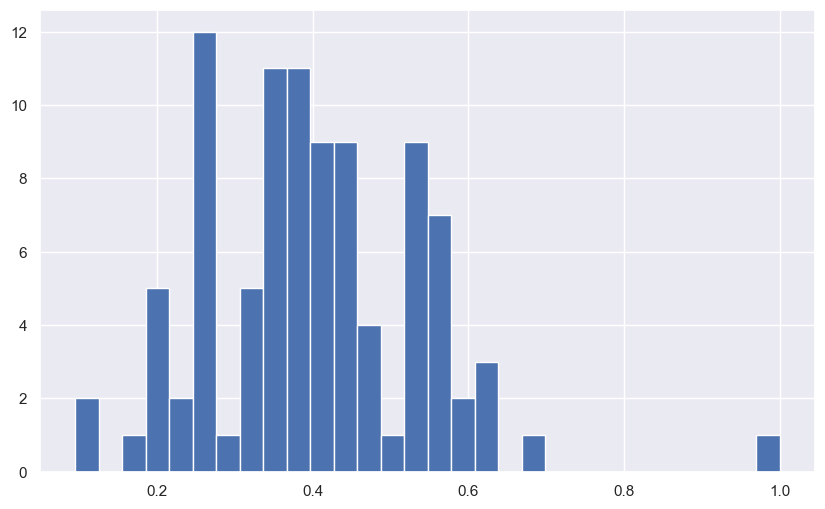

In [116]:
# Correlation with target
correlation_matrix = raw_data.iloc[:, :-5].corr()
print(correlation_matrix['y'].sort_values(ascending=False))
histogram = correlation_matrix['y'].hist(bins=30, figsize=(10, 6))

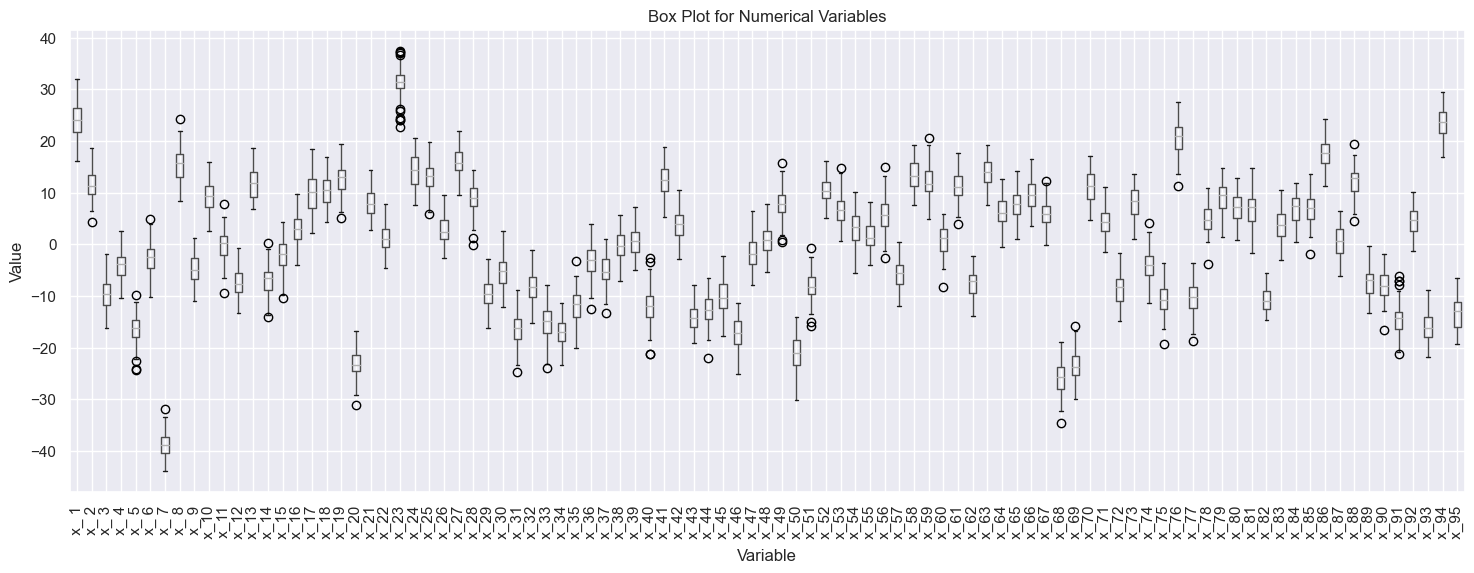

In [23]:

# Create box plots for numerical variables
plt.figure(figsize=(18, 6))  # Adjust the figure size if needed
X_num.boxplot(rot=90)
plt.title('Box Plot for Numerical Variables')
plt.xlabel('Variable')
plt.ylabel('Value')
plt.show()

## Models

### RIGHT BRANCH: Class data kept  

In [145]:
# Label encoder for categorical variables 
mapping = {'G': 1, 'H': 2, 'I': 3, 'J': 4, 'K': 5}
X_cat = X_cat.applymap(lambda x: mapping.get(str(x).strip(), x))
X_cat

,C_ 1,C_ 2,C_ 3,C_ 4,C_ 5
0,2.0,2,3,5,4
1,5.0,2,4,1,1
2,3.0,2,1,2,1
3,NaN,2,5,5,1
4,1.0,2,2,5,2
...,...,...,...,...,...
95,3.0,2,4,1,1
96,3.0,2,5,3,5
97,NaN,2,3,5,4
98,3.0,2,5,2,1


In [146]:
# Now X_num and X_cat are ready merging 
X = pd.concat([X_num, X_cat], axis=1)
X

,x_ 1,x_ 2,x_ 3,x_ 4,x_ 5,x_ 6,x_ 7,x_ 8,x_ 9,x_10,...,x_91,x_92,x_93,x_94,x_95,C_ 1,C_ 2,C_ 3,C_ 4,C_ 5
0,NaN,NaN,-3.978178,-1.504027,-14.986790,0.651581,-37.878245,16.213807,-3.965437,NaN,...,-7.032047,6.319109,NaN,26.197445,-9.913837,2.0,2,3,5,4
1,26.204958,11.185962,-8.247602,-3.875866,-11.329702,2.637900,-39.617497,NaN,-2.442164,10.303557,...,-13.437474,NaN,-12.880342,25.924603,-7.015803,5.0,2,4,1,1
2,18.560873,11.355342,-9.370161,-3.745315,-16.292421,-1.831774,-37.584605,14.411348,-2.376175,12.057741,...,-12.291624,2.664209,-15.803518,24.293073,-14.795709,3.0,2,1,2,1
3,31.896496,10.069040,-9.484426,-1.512786,-11.421909,-5.649180,-42.830037,18.403197,-7.791762,7.182760,...,-13.253436,5.004891,-13.879328,25.954304,-9.365574,NaN,2,5,5,1
4,25.400286,NaN,-3.600959,-2.615988,-15.455676,-4.950816,-39.932456,NaN,-7.341165,9.933879,...,NaN,5.101262,-16.938532,22.611184,-17.240003,1.0,2,2,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,24.821083,14.377228,-7.899269,-5.531786,NaN,-3.732251,NaN,15.752089,NaN,13.040789,...,-21.322369,4.998234,NaN,NaN,-11.750148,3.0,2,4,1,1
96,20.848176,9.238049,-11.921478,-6.374971,-18.648810,-3.019048,-41.358696,8.435083,-5.864114,6.372895,...,NaN,2.597797,-17.732465,20.164049,-15.924279,3.0,2,5,3,5
97,27.160523,10.134287,-10.920363,-3.231409,-18.474369,-2.431349,-38.280634,21.150995,-2.531643,12.875277,...,-13.586151,8.293394,-17.020511,23.697288,-10.619427,NaN,2,3,5,4
98,20.391153,10.180320,NaN,-5.296246,-17.612480,-6.472314,-38.292821,12.740686,NaN,4.037933,...,-16.653055,NaN,-17.575742,22.101534,-18.731196,3.0,2,5,2,1


#### Random Forest 

In [172]:
# Define the imputer
imputer = SimpleImputer(strategy='mean')

# Create a pipeline with imputation and the random forest model
pipeline = Pipeline([
    ('imputer', imputer),
    ('clf', RandomForestRegressor())
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'clf__n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
    'clf__max_depth': [int(x) for x in np.linspace(10, 110, num=11)] + [None],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__bootstrap': [True, False]
}

# Create RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid, n_iter=100, cv=5, verbose=2, n_jobs=-1)

# Fit the RandomizedSearchCV model
rf_random.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters:", rf_random.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END clf__bootstrap=True, clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=800; total time=   1.4s
[CV] END clf__bootstrap=True, clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=800; total time=   1.6s
[CV] END clf__bootstrap=True, clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=800; total time=   1.6s
[CV] END clf__bootstrap=False, clf__max_depth=50, clf__min_samples_leaf=1, clf__min_samples_split=10, clf__n_estimators=200; total time=   0.6s
[CV] END clf__bootstrap=False, clf__max_depth=50, clf__min_samples_leaf=1, clf__min_samples_split=10, clf__n_estimators=200; total time=   0.8s
[CV] END clf__bootstrap=True, clf__max_depth=70, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=800; total time=   1.7s
[CV] END clf__bootstrap=True, clf__max_depth=70, clf__min_samples_leaf=4, clf__mi

In [173]:
# Create predicitons 
y_pred = rf_random.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False) 
print(f"Root Mean Squared Error for Random Forest: {rmse}") 

Root Mean Squared Error for Random Forest: 36.61434201135048


##### - Investigation of Random Forest usability

In [162]:
# Add ten features of random noise to X_imp
## USED ONLY FOR INVESTIGATION  
X_imp = np.hstack([X, np.random.randn(X.shape[0], 10)])

In [163]:
###########
# This is the version that uses the imputer outside CV 
###########

# # Random forest regressor
# clf = RandomForestRegressor(bootstrap = True, oob_score = True, criterion = 'squared_error', random_state = 0)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.2, random_state=0, shuffle=False)


# # Try to experiment with criterion, number of estimators, max_depth, min_samples_leaf 
# # Try to add more of the parameters from the model and then add them to this dict to see how it affects the model.
# param_grid = {
#     'n_estimators': range(5,10), # range(5,101)
#     'max_depth': range(1,10), # range(1,11)
#     'max_features': range(10,20,20) # range(10,250,20)
# }

# rf_grid = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 5, verbose = 2, n_jobs = -1)

# # Fit the grid search model
# rf_grid.fit(X_train, y_train)

# #Save the results in a dataframe to disk
# df = pd.DataFrame(rf_grid.cv_results_)
# df.to_csv('CrossValidationResultsRandomForest.csv')

# print(rf_grid.best_estimator_)

# # If you just wanna read the saved results. 
# df = pd.read_csv(r'CrossValidationResultsRandomForest.csv')
# fig, ax = plt.subplots(figsize=(8,4))
# _ = sns.lineplot(data=df, x='param_max_depth', y='mean_test_score', hue='param_max_features', ax=ax)
# ax.set_xlabel('Maximum tree depth')
# ax.set_ylabel('Mean test accuracy')



#########################################################################################################

##########
# This is the version that uses the imputer inside CV, but not with Rasmus hyper parameter tuning 
##########


# Random forest regressor
clf = RandomForestRegressor(bootstrap=True, criterion='squared_error', random_state=0) # oob_score=True

# Define the imputer
imputer = SimpleImputer(strategy='mean')

# Create a pipeline with imputation and the random forest model
pipeline = Pipeline([
    ('imputer', imputer),
    ('clf', clf)])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.2, random_state=0, shuffle=False) # used X_imp when investigating 

# Try to experiment with criterion, number of estimators, max_depth, min_samples_leaf
# Try to add more of the parameters from the model and then add them to this dict to see how it affects the model.
param_grid = {
    'clf__n_estimators': range(5, 10),  # range(5, 101)
    'clf__max_depth': range(1, 10),  # range(1, 11)
    'clf__max_features': range(10, 20, 20)  # range(10, 250, 20)
}

# Create GridSearchCV with the pipeline
rf_grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

# Fit the grid search model
rf_grid.fit(X_train, y_train)

print(rf_grid.best_estimator_)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV] END clf__max_depth=1, clf__max_features=10, clf__n_estimators=5; total time=   0.0s
[CV] END clf__max_depth=1, clf__max_features=10, clf__n_estimators=5; total time=   0.0s
[CV] END clf__max_depth=1, clf__max_features=10, clf__n_estimators=5; total time=   0.0s
[CV] END clf__max_depth=1, clf__max_features=10, clf__n_estimators=5; total time=   0.0s
[CV] END clf__max_depth=1, clf__max_features=10, clf__n_estimators=6; total time=   0.0s
[CV] END clf__max_depth=1, clf__max_features=10, clf__n_estimators=6; total time=   0.0s
[CV] END clf__max_depth=1, clf__max_features=10, clf__n_estimators=5; total time=   0.0s
[CV] END clf__max_depth=1, clf__max_features=10, clf__n_estimators=6; total time=   0.0s
[CV] END clf__max_depth=1, clf__max_features=10, clf__n_estimators=7; total time=   0.0s
[CV] END clf__max_depth=1, clf__max_features=10, clf__n_estimators=6; total time=   0.0s
[CV] END clf__max_depth=1, clf__max_features=10,

In [164]:
y_pred = rf_grid.predict(X_test)

In [165]:
# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False) 
print(f"Root mean Squared Error: {rmse}") 

Root mean Squared Error: 57.2171736845385


In [166]:
# Mean importance values across permutations
imp = permutation_importance(rf_grid, X_train, y_train, n_repeats=10,random_state=0, scoring = 'neg_root_mean_squared_error')
imp.importances_mean 
# The higher the mean importance, the more impactful the feature is in terms of model performance.

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.59237049e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.47770717e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        6.37492671e-01,  1.91731262e-01,  7.59163439e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.17654761e+00,  0.00000000e+00,
        0.00000000e+00,  3.56376368e-01,  6.05293948e-02,  4.05576761e+00,
        5.52217030e-01,  4.10883196e-01,  3.13184025e-03,  1.78106994e+00,
        0.00000000e+00, -8.28726405e-02,  7.06896949e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.54672894e-02,  0.00000000e+00,
        6.27525382e-01,  0.00000000e+00,  2.12198417e+00,  0.00000000e+00,
        0.00000000e+00,  2.06009005e+00,  5.76900297e-01,  3.77911615e+00,
        0.00000000e+00,  1.62386224e-01,  0.00000000e+00,  2.88578346e-01,
        0.00000000e+00,  2.60587767e-01,  8.07425269e-01,  6.48949754e-02,
        1.07073861e+00,  

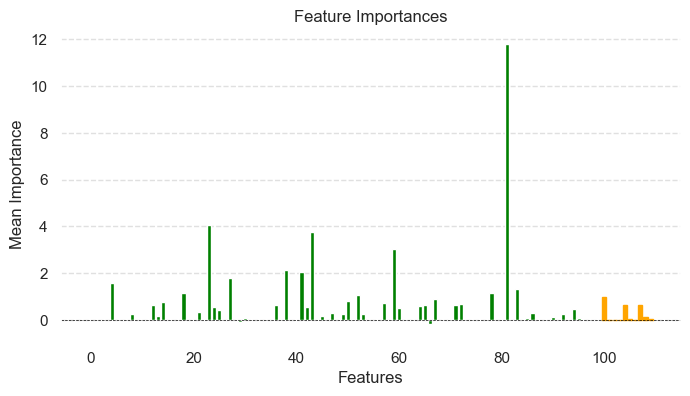

In [167]:
# Plot of feature importance 

## ONLY USED FOR INVESTIGATION 
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_facecolor('white')
bars = ax.bar(range(len(imp.importances_mean)), imp.importances_mean, color='green')
for i in range(-10, 0):
    bars[i].set_color('orange')
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)  # Add a horizontal line at y=0 for reference
# plt.xticks(range(len(imp.importances_mean)), X.columns, rotation=45, ha='right')  
ax.set_xlabel('Features')
ax.set_ylabel('Mean Importance')
ax.set_title('Feature Importances')
ax.grid(axis='y', linestyle='--', alpha=0.7, color="lightgrey")
plt.show()

#### Gradient Boosting Regressor

In [179]:
# Split the data into training and testing sets (without shuffling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': [None, 10, 20],
    'random_state': [0],
    'early_stopping': [True],
    'validation_fraction': [0.1, 0.2, 0.3]
}

# Create RandomizedSearchCV with HistGradientBoostingRegressor directly
gb_random = RandomizedSearchCV(estimator=HistGradientBoostingRegressor(), param_distributions=param_grid, n_iter=100, cv=5, verbose=2, n_jobs=-1)

# Fit the RandomizedSearchCV model
gb_random.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters:", gb_random.best_params_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END early_stopping=True, learning_rate=0.1, max_depth=20, max_iter=200, max_leaf_nodes=20, min_samples_leaf=4, random_state=0, validation_fraction=0.1; total time=   0.1s
[CV] END early_stopping=True, learning_rate=0.01, max_depth=20, max_iter=100, max_leaf_nodes=20, min_samples_leaf=2, random_state=0, validation_fraction=0.2; total time=   0.1s
[CV] END early_stopping=True, learning_rate=0.1, max_depth=20, max_iter=200, max_leaf_nodes=20, min_samples_leaf=4, random_state=0, validation_fraction=0.1; total time=   0.1s
[CV] END early_stopping=True, learning_rate=0.1, max_depth=20, max_iter=200, max_leaf_nodes=20, min_samples_leaf=4, random_state=0, validation_fraction=0.1; total time=   0.2s
[CV] END early_stopping=True, learning_rate=0.1, max_depth=20, max_iter=200, max_leaf_nodes=20, min_samples_leaf=4, random_state=0, validation_fraction=0.1; total time=   0.2s
[CV] END early_stopping=True, learning_rate=0.1, max_dep

In [180]:
# Create predictions 
y_pred = gb_random.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False) 
print(f"Root Mean Squared Error for Gradient Boosting: {rmse}") 

Root Mean Squared Error for Gradient Boosting: 50.23311403571463


Below here, I tried using the imputation anyways, and it gives slightly better results than not imputing 

In [177]:
# Define the imputer
imputer = SimpleImputer(strategy='mean')

# Create a pipeline with imputation and the gradient boosting model
pipeline = Pipeline([
    ('imputer', imputer),
    ('clf', HistGradientBoostingRegressor())
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__max_iter': [100, 200, 300],
    'clf__max_depth': [10, 20, 30],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_leaf_nodes': [None, 10, 20],
    'clf__random_state': [0],
    'clf__early_stopping': [True],
    'clf__validation_fraction': [0.1, 0.2, 0.3]
}

# Create RandomizedSearchCV
gb_random = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid, n_iter=100, cv=5, verbose=2, n_jobs=-1)

# Fit the RandomizedSearchCV model
gb_random.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters:", gb_random.best_params_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END clf__early_stopping=True, clf__learning_rate=0.1, clf__max_depth=20, clf__max_iter=100, clf__max_leaf_nodes=None, clf__min_samples_leaf=2, clf__random_state=0, clf__validation_fraction=0.1; total time=   0.2s
[CV] END clf__early_stopping=True, clf__learning_rate=0.1, clf__max_depth=20, clf__max_iter=100, clf__max_leaf_nodes=None, clf__min_samples_leaf=2, clf__random_state=0, clf__validation_fraction=0.1; total time=   0.3s
[CV] END clf__early_stopping=True, clf__learning_rate=0.1, clf__max_depth=20, clf__max_iter=100, clf__max_leaf_nodes=None, clf__min_samples_leaf=2, clf__random_state=0, clf__validation_fraction=0.1; total time=   0.4s
[CV] END clf__early_stopping=True, clf__learning_rate=0.1, clf__max_depth=20, clf__max_iter=100, clf__max_leaf_nodes=None, clf__min_samples_leaf=2, clf__random_state=0, clf__validation_fraction=0.1; total time=   0.3s
[CV] END clf__early_stopping=True, clf__learning_rate=0.01, clf__

In [178]:
# Create predictions 
y_pred = gb_random.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False) 
print(f"Root Mean Squared Error for Gradient Boosting: {rmse}") 

Root Mean Squared Error for Gradient Boosting: 42.79845455758921


#### L1 Lasso Regression EMMA

### LEFT BRANCH: Models on class data RASMUS

## Model Validation

In [ ]:

 


###############################################################
# Fix missing data 
###############################################################

# Fix missing data for numerical columns
for column in X_num.columns:
    if X_num[column].isnull().any():
        mean_value = X_num[column].mean()
        X_num = X_num[column].fillna(mean_value, inplace=True)

# Fix missing data for categorical columns
for column in X_cat.columns:
    if X_cat[column].isnull().any():
        mode_value = X_cat[column].mode().iloc[0]  # using mode for categorical data
        X_cat = X_cat[column].fillna(mode_value, inplace=True)

# Concatenate the imputed numerical and categorical data
data = pd.concat([y, X_num, X_cat], axis=1)


###############################################################
# Feature handling: categorical data 
###############################################################
# https://www.saedsayad.com/decision_tree_reg.htm
# We do decison tree regression for the categorical data
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor # it does one hot encoding in the background
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# Make it numpy
X_cat_np = X_cat.to_numpy()

# Label encode the categorical data, so that the labels are translated to usable data
label_encoders = []
for i in range(len(X_cat_np[0])):
    label_encoders.append(LabelEncoder())
    X_cat_np[:, i] = label_encoders[i].fit_transform([row[i] for row in X_cat_np])

regressor = DecisionTreeRegressor()
regressor.fit(X_cat_np, y)
y_pred = regressor.predict(X_cat_np)

mean_squared_error(y, y_pred)

importances = regressor.feature_importances_




###############################################################
# Other data transformations 
###############################################################



###############################################################
# Prediction model: ??? 
###############################################################